In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

#shift-tab on a function gets its docstring

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)

import constants
imp.reload(constants)
from constants import *

In [4]:
from lalwaveform import dimensionless_td_waveform, dimensionless_fd_waveform
import pycbc.waveform

In [5]:
from scipy import stats

# Make training set and save it to a file

In [6]:
def uniform_grid(n, limits):
    """This is really stupid.
    """
    points = []
    for i in range(n):
        xmin, xmax = limits[0, 0], limits[0, 1]
        x0 = np.linspace(xmin, xmax, n)
        for j in range(n):
            xmin, xmax = limits[1, 0], limits[1, 1]
            x1 = np.linspace(xmin, xmax, n)
            for k in range(n):
                xmin, xmax = limits[2, 0], limits[2, 1]
                x2 = np.linspace(xmin, xmax, n)
                for l in range(n):
                    xmin, xmax = limits[3, 0], limits[3, 1]
                    x3 = np.linspace(xmin, xmax, n)
                    for m in range(n):
                        xmin, xmax = limits[4, 0], limits[4, 1]
                        x4 = np.linspace(xmin, xmax, n)
                        
                        point = [x0[i], x1[j], x2[k], x3[l], x4[m]]
                        #print point
                        points.append(point)
    #print points
    return np.array(points)

In [7]:
# Parameters for the training set

limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
corners = uniform_grid(2, limits)

Ndata = 512
lhd = doe.latin_hypercube(Ndata, limits)
params = np.concatenate((corners, lhd))

params.shape

(544, 5)

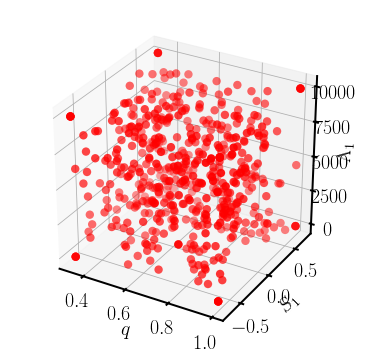

In [8]:
fig = plt.figure(figsize=(6, 6))
axes = fig.add_subplot(111, projection='3d')
x, y, z = params[:, 0], params[:, 1], params[:, 3]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$\Lambda_1$')

In [9]:
print [np.min(params[:, j]) for j in range(5)]
print [np.max(params[:, j]) for j in range(5)]

[0.33333333333333331, -0.69999999999999996, -0.69999999999999996, 0.0, 0.0]
[1.0, 0.69999999999999996, 0.69999999999999996, 10000.0, 10000.0]


In [10]:
########################################################
#     The parameters to be used for all waveforms      #
########################################################

f_min = 0.0004
delta_t = 10.0
approximant = 'SpinTaylorT4'
amp_ord = 0

min_total_time = 4.0*train.zero_pn_coalescence_time(f_min, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)
print min_total_time, n_ext

winon_i = f_min
winon_f = 0.0005
winoff_i = 0.008
winoff_f = 0.009
trunc_i = winon_f
trunc_f = 0.010
#trunc_f = MF_ISCO
npoints = 10000
win = 'planck'
f_coalescence = winoff_f

ref_delta_f = 1.0e-8

16993795.3652 2097152


In [11]:
h_filename = '../data/h_training_set.hdf5'
dh_filename = '../data/dh_training_set.hdf5'

train.make_training_set(
    h_filename, dh_filename, params,
    f_min, delta_t, 
    winon_i, winon_f, winoff_i, winoff_f, 
    n_ext,
    trunc_i, trunc_f, ref_delta_f, npoints=npoints, 
    win=win, f_coalescence=f_coalescence, remove_start_phase=True, 
    approximant=approximant, amplitude_order=amp_ord)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [11]:
# Generate the randomly sampled set
Ndata = 1000
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
params = doe.uniform_random_samples(Ndata, limits)

h_filename = '../data/h_test_set_rand.hdf5'
dh_filename = '../data/dh_test_set_rand.hdf5'

train.make_training_set(
    h_filename, dh_filename, params,
    f_min, delta_t, 
    winon_i, winon_f, winoff_i, winoff_f, 
    n_ext,
    trunc_i, trunc_f, ref_delta_f, npoints=npoints, 
    win=win, f_coalescence=f_coalescence, remove_start_phase=True, 
    approximant=approximant, amplitude_order=amp_ord)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [13]:
q = 0.6
spin1z_arr = np.linspace(-0.7, 0.7, 51)
spin2z = 0.2
lambda1 = 2000.0
lambda2 = 1000.0
params = np.array([[q, spin1z, spin2z, lambda1, lambda2] for spin1z in spin1z_arr])

h_filename = '../data/h_test_set_uniform.hdf5'
dh_filename = '../data/dh_test_set_uniform.hdf5'

train.make_training_set(
    h_filename, dh_filename, params,
    f_min, delta_t, 
    winon_i, winon_f, winoff_i, winoff_f, 
    n_ext,
    trunc_i, trunc_f, ref_delta_f, npoints=npoints, 
    win=win, f_coalescence=f_coalescence, remove_start_phase=True, 
    approximant=approximant, amplitude_order=amp_ord)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


# Plots of training set

In [14]:
h_trainset = ws.HDF5WaveformSet('../data/h_training_set.hdf5')
dh_trainset = ws.HDF5WaveformSet('../data/dh_training_set.hdf5')

In [15]:
h_testset_rand = ws.HDF5WaveformSet('../data/h_test_set_rand.hdf5')
dh_testset_rand = ws.HDF5WaveformSet('../data/dh_test_set_rand.hdf5')

In [16]:
h_testset_uni = ws.HDF5WaveformSet('../data/h_test_set_uniform.hdf5')
dh_testset_uni = ws.HDF5WaveformSet('../data/dh_test_set_uniform.hdf5')

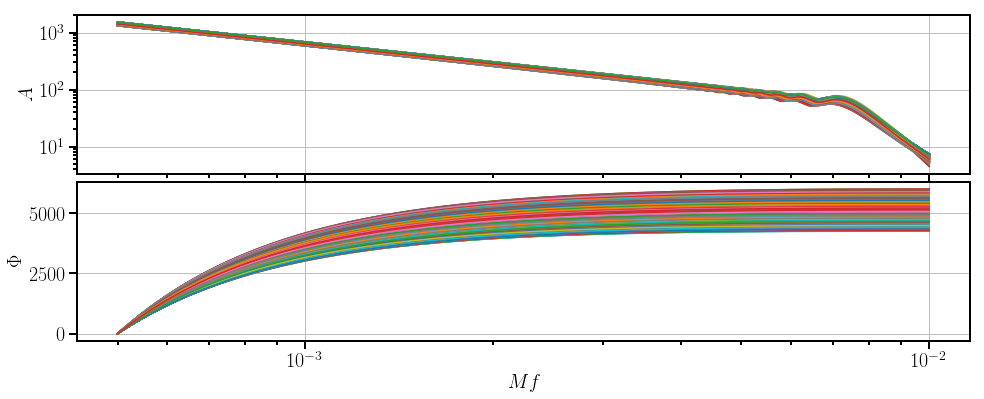

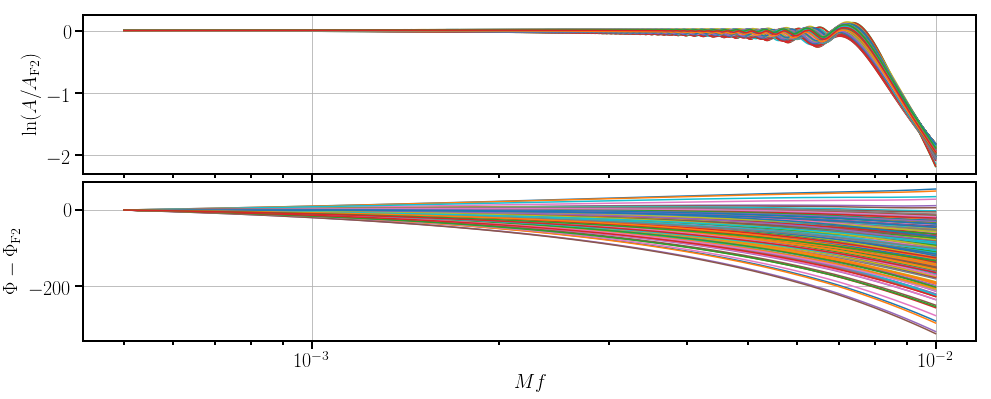

In [17]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_trainset[i] for i in range(len(h_trainset))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_trainset[i] for i in range(len(dh_trainset))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

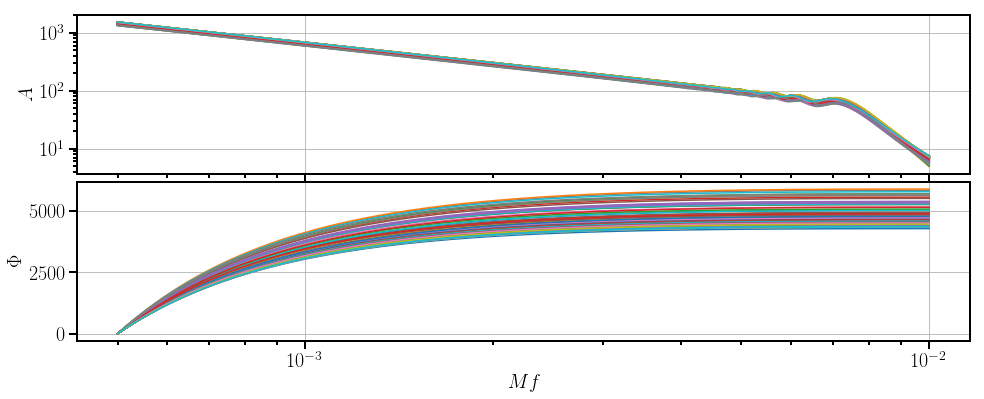

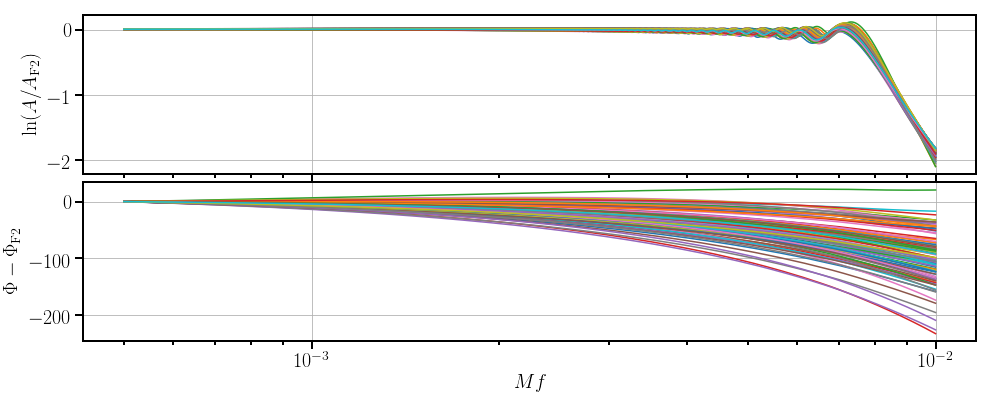

In [18]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_testset_rand[i] for i in range(len(h_testset_rand))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_testset_rand[i] for i in range(len(dh_testset_rand))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

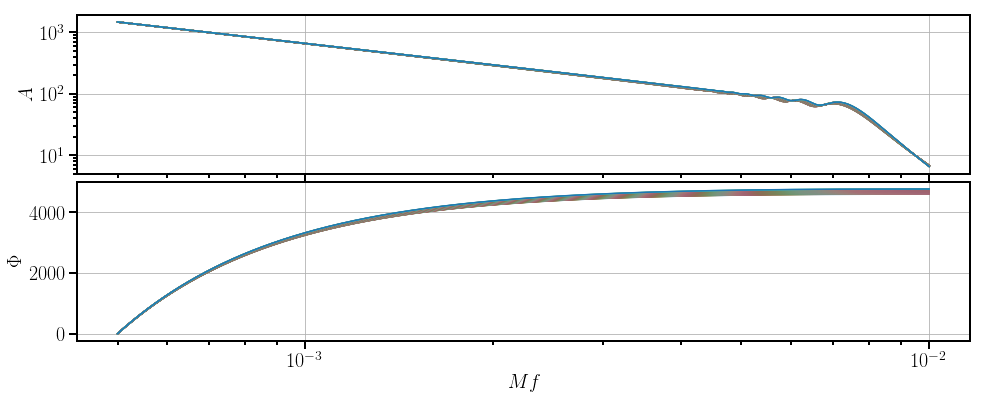

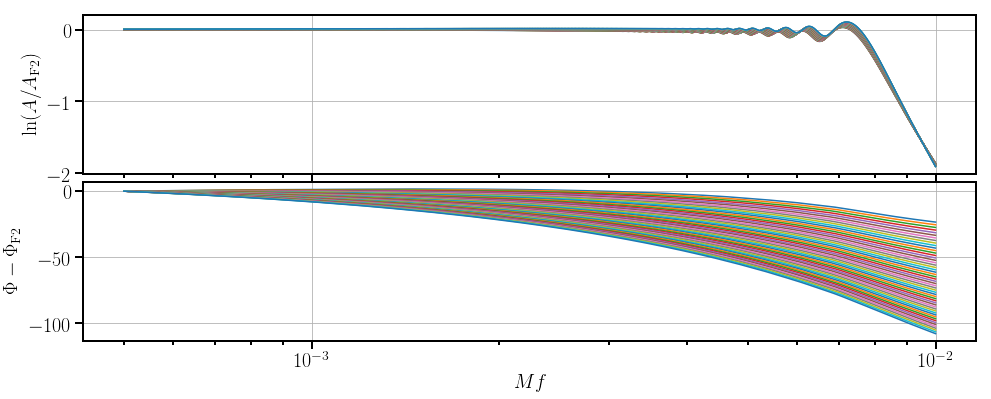

In [19]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_testset_uni[i] for i in range(len(h_testset_uni))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_testset_uni[i] for i in range(len(dh_testset_uni))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Analyze variation with respect to waveform parameters
1. Check that dh variation is much smaller than h variation.
2. Check that amp/phase vary smoothly as a function of waveform parameters.

In [20]:
def range_of_freq(h_list):
    """Calculate the max and min values of the amplitude and range
    as a function of frequency.
    """
    freq = h_list[0].x
    nwave = len(h_list)
    nfreq = len(freq)
    
    amps = np.array([h_list[i].amp for i in range(nwave)])
    amp_min = np.array([np.min(amps[:, j]) for j in range(nfreq)])
    amp_max = np.array([np.max(amps[:, j]) for j in range(nfreq)])
    
    phases = np.array([h_list[i].phase for i in range(nwave)])
    phase_min = np.array([np.min(phases[:, j]) for j in range(nfreq)])
    phase_max = np.array([np.max(phases[:, j]) for j in range(nfreq)])
    
    return freq, amp_min, amp_max, phase_min, phase_max

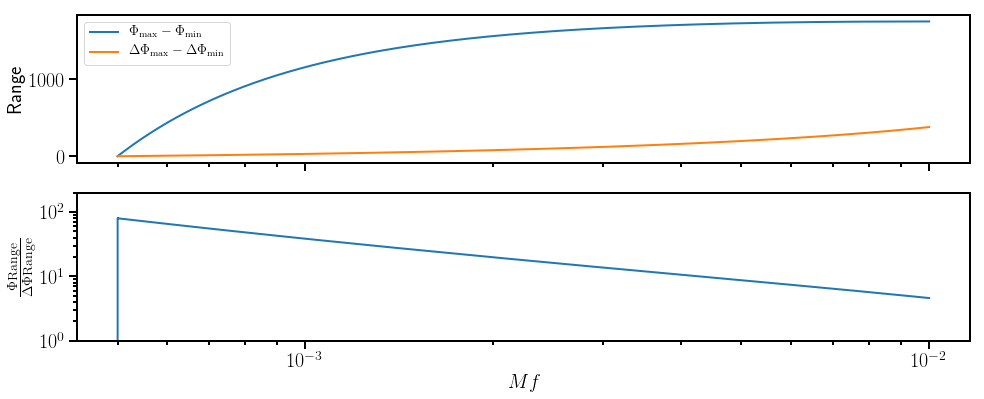

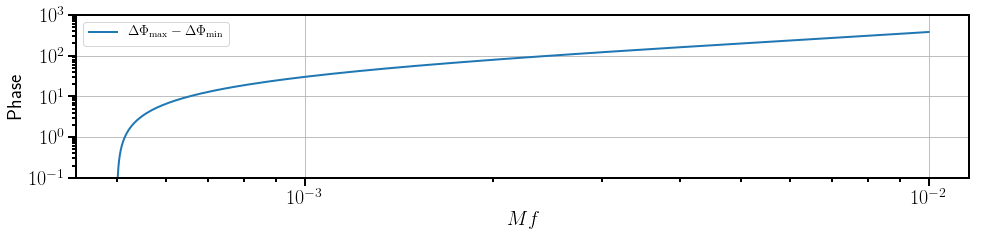

In [21]:
freq1, amp_min1, amp_max1, phase_min1, phase_max1 = range_of_freq(h_trainset)
freq2, amp_min2, amp_max2, phase_min2, phase_max2 = range_of_freq(dh_trainset)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16, 6))

ax1.plot(freq1, phase_max1-phase_min1, ls='-', lw=2, label=r'$\Phi_{\rm max}-\Phi_{\rm min}$')
ax1.plot(freq2, phase_max2-phase_min2, ls='-', lw=2, label=r'$\Delta\Phi_{\rm max}-\Delta\Phi_{\rm min}$')
ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_ylim(0.1, 1.0e4)
ax1.set_ylabel('Range')
ax1.legend()

ax2.plot(freq1, (phase_max1-phase_min1)/(phase_max2-phase_min2), ls='-', lw=2)
#ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(1.0, 200.)
ax2.set_xlabel('$Mf$')
ax2.set_ylabel(r'$\frac{\Phi{\rm Range}}{\Delta\Phi {\rm Range}}$')



fig, ax1 = plt.subplots(1, figsize=(16, 3))
ax1.plot(freq2, phase_max2-phase_min2, ls='-', lw=2, label=r'$\Delta\Phi_{\rm max}-\Delta\Phi_{\rm min}$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1.0e-1, 1.0e3)
ax1.set_ylabel('Phase')
ax1.set_xlabel('$Mf$')
ax1.legend()
ax1.grid()

0.01 725.090869704


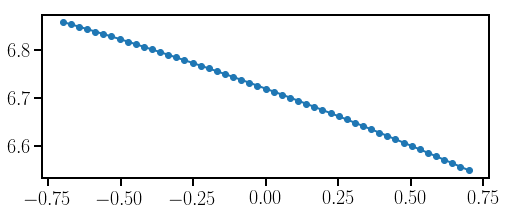

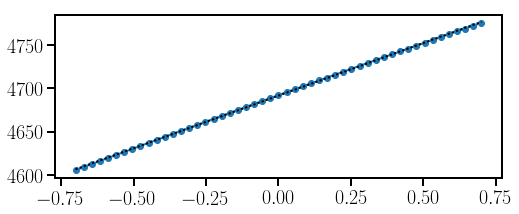

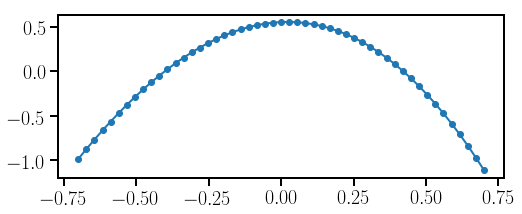

In [23]:
mf = 0.01
print mf, mf_to_f(mf, 2.8)

ps = []
amps = []
for i in range(len(h_testset_uni)):
    p = h_testset_uni.get_waveform(i, data='parameters')[1]
    h = h_testset_uni[i]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)

ps = []
phases = []
for i in range(len(h_testset_uni)):
    p = h_testset_uni.get_waveform(i, data='parameters')[1]
    h = h_testset_uni[i]
    phase = h.interpolate('phase')(mf)
    ps.append(p)
    phases.append(phase)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(ps, phases)
x_fit = spin1z_arr
y_fit = intercept + slope*x_fit

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases, 'o', ls='-', lw=2)
axes.plot(x_fit, y_fit, ls=':', lw=2, c='k')

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases-y_fit, 'o', ls='-', lw=2)

0.01 725.090869704


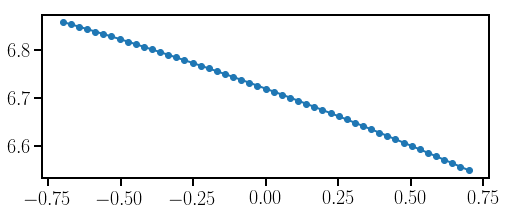

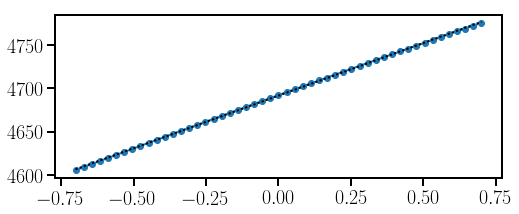

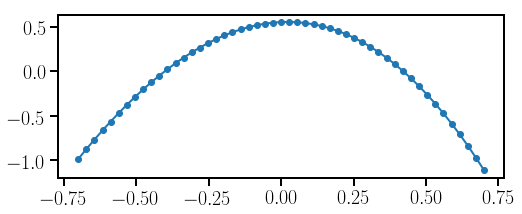

In [25]:
mf = 0.01
print mf, mf_to_f(mf, 2.8)

ps = []
amps = []
for i in range(len(h_testset_uni)):
    p = h_testset_uni.get_waveform(i, data='parameters')[1]
    h = h_testset_uni[i]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
amps = np.array(amps)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)

ps = []
phases = []
for i in range(len(h_testset_uni)):
    p = h_testset_uni.get_waveform(i, data='parameters')[1]
    h = h_testset_uni[i]
    phase = h.interpolate('phase')(mf)
    ps.append(p)
    phases.append(phase)
phases=np.array(phases)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(ps, phases)
x_fit = spin1z_arr
y_fit = intercept + slope*x_fit

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases, 'o', ls='-', lw=2)
axes.plot(x_fit, y_fit, ls=':', lw=2, c='k')

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases-y_fit, 'o', ls='-', lw=2)